In [107]:
!pip install torch_geometric
!pip install transformers

In [108]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv

from transformers import BertModel, BertTokenizer

import plotly.figure_factory as ff


## GNN + Mean Similarity as similarity metric 

In [109]:
# df_load = pd.read_csv("/kaggle/input/preprocessed-single-label-csv/preprocessed_single_label.csv", index_col=0)
df_load = pd.read_csv("dataset/preprocessed_single_label.csv", index_col=0)
list_genres = ["Blues", "Gospel/Religioso", "Heavy Metal", "Rap"]
df_load = df_load[df_load["Genres"].isin(list_genres)]
genre_counts = df_load['Genres'].value_counts()
smallest_size = genre_counts.min()
df = df_load.groupby('Genres').sample(n = smallest_size, random_state=42)

In [110]:
df

,Titel,Lyric,Artist,Genres
20300,Fool That I Am,fool falling love fool thinking loved took hea...,Etta James,Blues
20989,Tomorrow Night,tomorrow night remember said tonight tomorrow ...,BB King,Blues
21894,She Moves Me,moves man honey dont see done moves man honey ...,Muddy Waters,Blues
22456,Old Before My Time,long hard road follows behind cold im die chas...,The Allman Brothers Band,Blues
22588,Everybody Wants To Go To Heaven,evrybody wants laugh ah nobody wants cry say e...,Albert King,Blues
...,...,...,...,...
301443,Dave Has a Problem... Seriously,dave problem seriously dove yo merc dave hello...,De La Soul,Rap
298126,Self Conscience,yo ill need fixed shit real dunn stop talkin l...,Nas,Rap
297955,Black Girl Lost,click dialtone numbers dialed phone rings pick...,Nas,Rap
298399,Mistress,verse moving fast knew wouldnt last thats wore...,Cupcakke,Rap


In [111]:
label_encoder = LabelEncoder()
df['Genre_encoded'] = label_encoder.fit_transform(df['Genres'])

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [113]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figsize for better label fit
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    
    plt.title('Confusion Matrix', fontsize=16, pad=20)  # Adjust title padding
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)  # Keep y-axis labels horizontal
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()

In [114]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['Lyric'])

genre_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=df['Genres'], columns=vectorizer.get_feature_names_out())
mean_tfidf_by_genre = genre_tfidf.groupby('Genres').mean()

similarity_matrix = cosine_similarity(mean_tfidf_by_genre)
similarity_df = pd.DataFrame(similarity_matrix, index=mean_tfidf_by_genre.index, columns=mean_tfidf_by_genre.index)


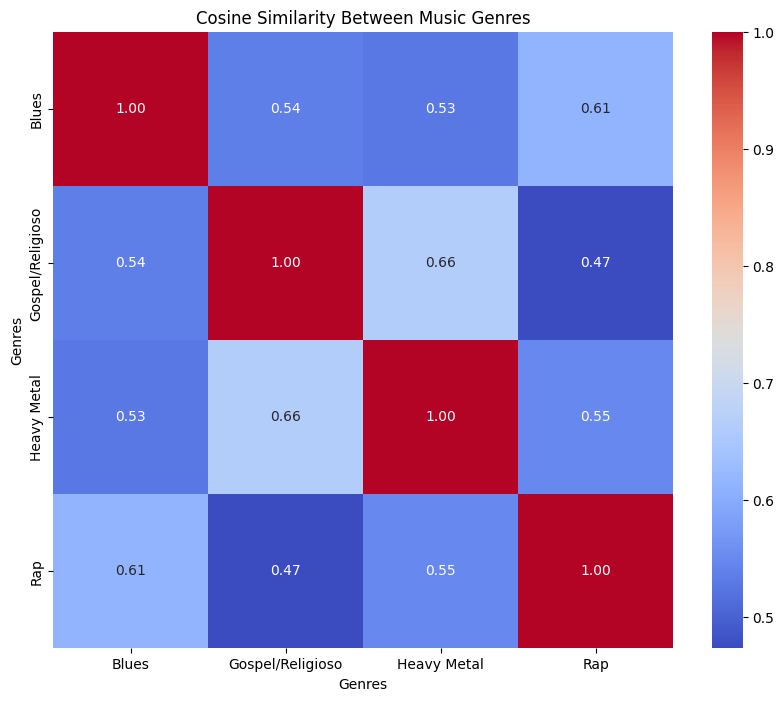

In [115]:
plt.figure(figsize=(10, 8))

sns.heatmap(similarity_df, 
            annot=True,   # Optionally add annotations to each cell
            fmt=".2f",    # Formatting the annotation if `annot` is True
            cmap='coolwarm',  # Color map style
            xticklabels=similarity_df.columns,  # Ensuring labels are genre names
            yticklabels=similarity_df.index)

plt.title('Cosine Similarity Between Music Genres')
plt.xlabel('Genres')
plt.ylabel('Genres')

plt.show()

In [116]:
def mean_similarity(combination):
    sub_matrix = similarity_df.loc[combination, combination]
    mean_sim = np.mean([sub_matrix.iloc[i, j] for i in range(len(combination)) for j in range(i+1, len(combination))])
    return mean_sim

def plot_tsne_for_genres(df, genre_subset, title_suffix):
    filtered_df = df[df['Genres'].isin(genre_subset)]
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(filtered_df['Lyric'])
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X.toarray())
    
    filtered_df['tsne-2d-one'] = tsne_results[:,0]
    filtered_df['tsne-2d-two'] = tsne_results[:,1]

    Q1_tsne_one = np.percentile(filtered_df['tsne-2d-one'], 25)
    Q3_tsne_one = np.percentile(filtered_df['tsne-2d-one'], 75)
    IQR_tsne_one = Q3_tsne_one - Q1_tsne_one
    Q1_tsne_two = np.percentile(filtered_df['tsne-2d-two'], 25)
    Q3_tsne_two = np.percentile(filtered_df['tsne-2d-two'], 75)
    IQR_tsne_two = Q3_tsne_two - Q1_tsne_two

    x_min, x_max = Q1_tsne_one - 1.5 * IQR_tsne_one, Q3_tsne_one + 1.5 * IQR_tsne_one
    y_min, y_max = Q1_tsne_two - 1.5 * IQR_tsne_two, Q3_tsne_two + 1.5 * IQR_tsne_two

    plt.figure(figsize=(12,8))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Genres",
        palette=sns.color_palette("rainbow", len(genre_subset)),
        data=filtered_df,
        legend="full",
        s=30,
        alpha=0.5
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f't-SNE Visualization of {title_suffix}')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    plt.show()

In [117]:
genre_combinations = list(combinations(similarity_df.index, 4))


mean_similarities = [(combo, mean_similarity(combo)) for combo in genre_combinations]

min_similarity_combo = min(mean_similarities, key=lambda x: x[1])
max_similarity_combo = max(mean_similarities, key=lambda x: x[1])

print("Combination with the smallest mean similarity:", min_similarity_combo[0])
print("Mean similarity:", min_similarity_combo[1])

print("Combination with the maximum mean similarity:", max_similarity_combo[0])
print("Mean similarity:", max_similarity_combo[1])

Combination with the smallest mean similarity: ('Blues', 'Gospel/Religioso', 'Heavy Metal', 'Rap')
Mean similarity: 0.5603520906430358
Combination with the maximum mean similarity: ('Blues', 'Gospel/Religioso', 'Heavy Metal', 'Rap')
Mean similarity: 0.5603520906430358


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4252 samples in 0.003s...
[t-SNE] Computed neighbors for 4252 samples in 0.495s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4252
[t-SNE] Computed conditional probabilities for sample 2000 / 4252
[t-SNE] Computed conditional probabilities for sample 3000 / 4252
[t-SNE] Computed conditional probabilities for sample 4000 / 4252
[t-SNE] Computed conditional probabilities for sample 4252 / 4252
[t-SNE] Mean sigma: 0.382908
[t-SNE] KL divergence after 250 iterations with early exaggeration: 109.602386
[t-SNE] KL divergence after 300 iterations: 5.055242


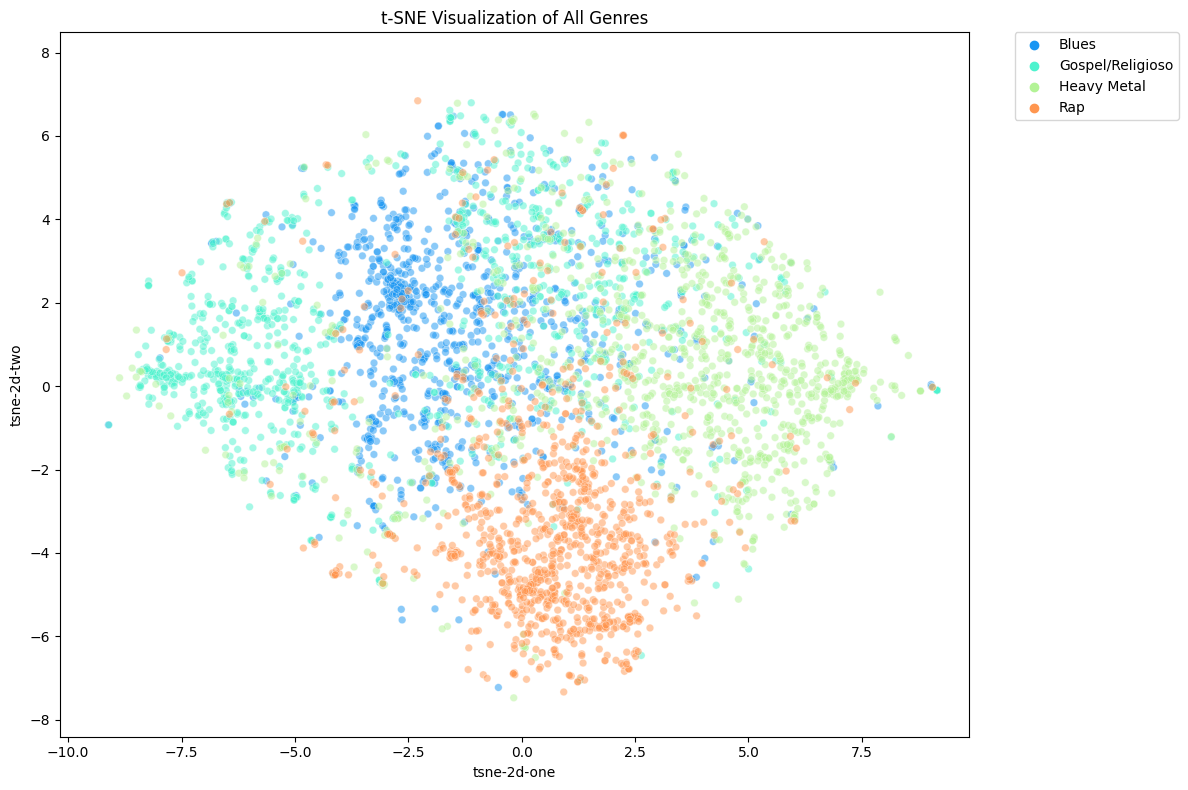

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4252 samples in 0.003s...
[t-SNE] Computed neighbors for 4252 samples in 0.455s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4252
[t-SNE] Computed conditional probabilities for sample 2000 / 4252
[t-SNE] Computed conditional probabilities for sample 3000 / 4252
[t-SNE] Computed conditional probabilities for sample 4000 / 4252
[t-SNE] Computed conditional probabilities for sample 4252 / 4252
[t-SNE] Mean sigma: 0.382908
[t-SNE] KL divergence after 250 iterations with early exaggeration: 120.753342
[t-SNE] KL divergence after 300 iterations: 6.130996


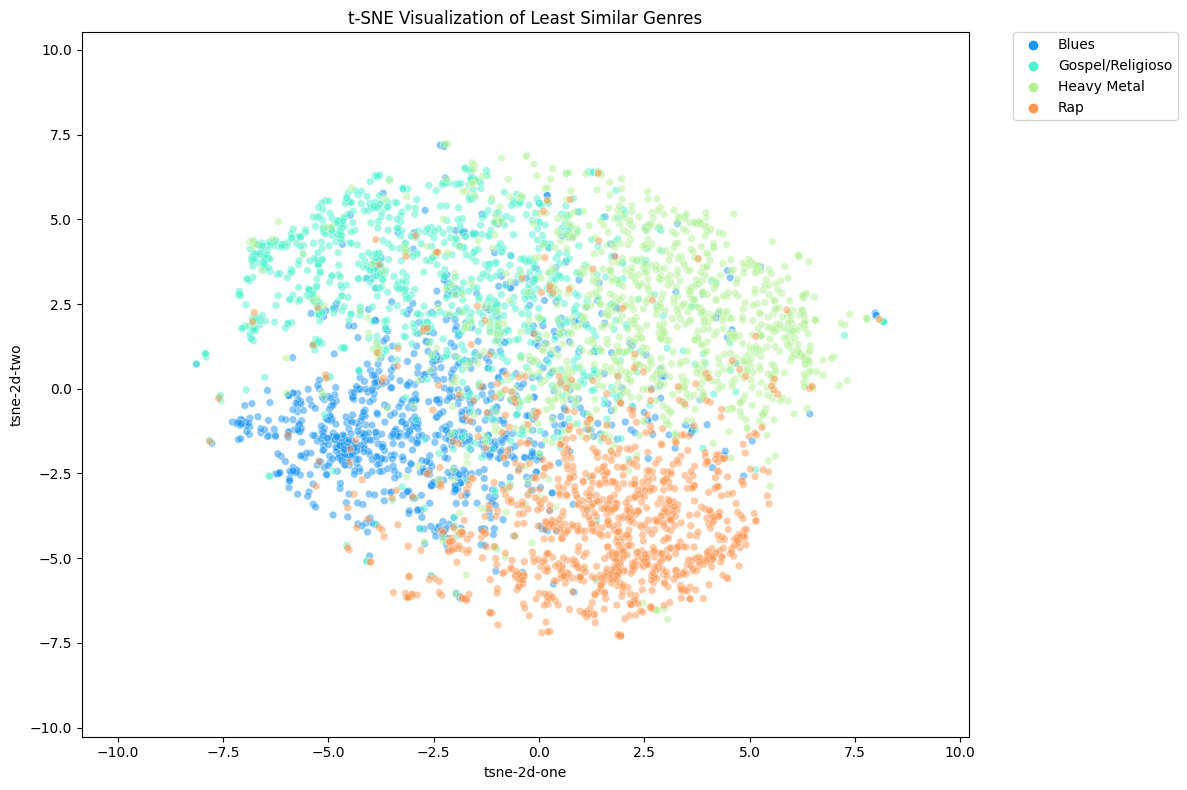

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4252 samples in 0.003s...
[t-SNE] Computed neighbors for 4252 samples in 0.439s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4252
[t-SNE] Computed conditional probabilities for sample 2000 / 4252
[t-SNE] Computed conditional probabilities for sample 3000 / 4252
[t-SNE] Computed conditional probabilities for sample 4000 / 4252
[t-SNE] Computed conditional probabilities for sample 4252 / 4252
[t-SNE] Mean sigma: 0.382908
[t-SNE] KL divergence after 250 iterations with early exaggeration: 112.800880
[t-SNE] KL divergence after 300 iterations: 5.430413


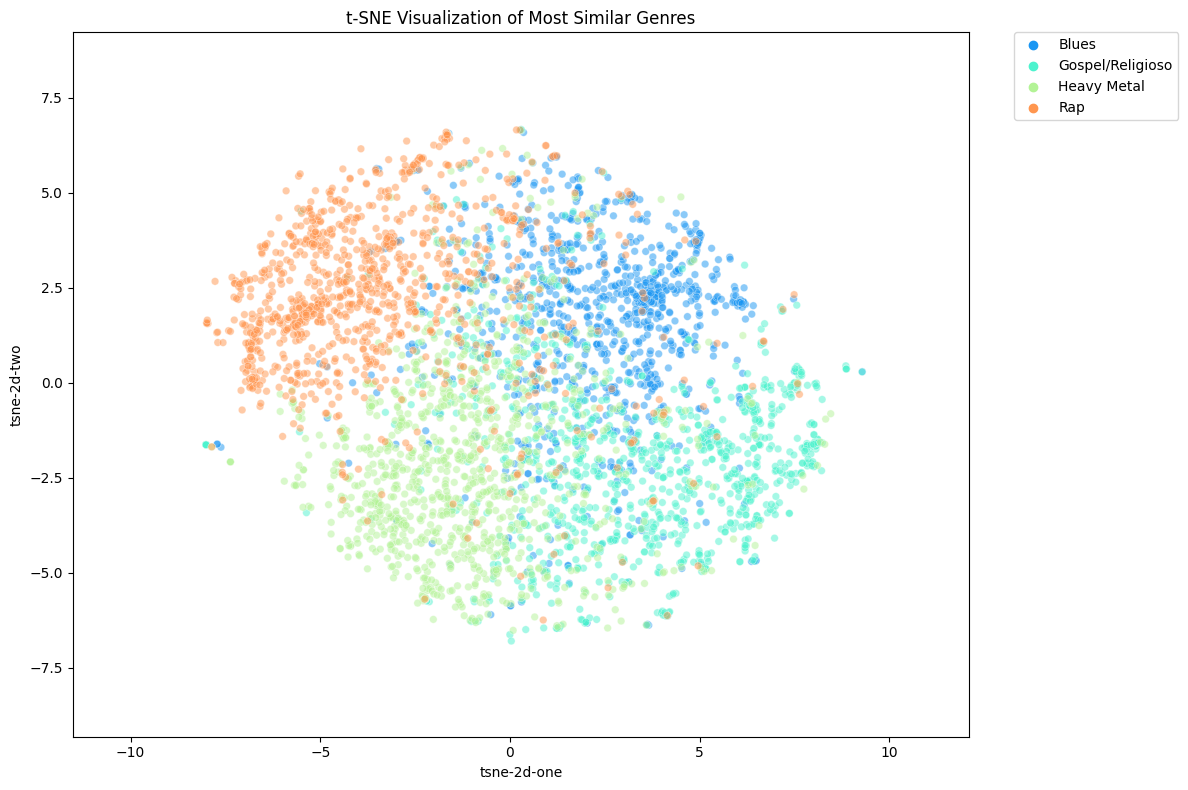

In [118]:
plot_tsne_for_genres(df, df['Genres'].unique(), "All Genres")
plot_tsne_for_genres(df, min_similarity_combo[0], "Least Similar Genres")
plot_tsne_for_genres(df, max_similarity_combo[0], "Most Similar Genres")

In [119]:
# Compute cosine similarity for all samples
cos_sim_matrix = cosine_similarity(tfidf_matrix)

# Create adjacency matrix with threshold
threshold = 0.001  # You can adjust this threshold
adj_matrix = (cos_sim_matrix > threshold).astype(int)
np.fill_diagonal(adj_matrix, 0)  # Remove self-loops

# Splitting the data while ensuring adjacency matrix consistency
X_train, X_test, y_train, y_test, adj_train, adj_test = train_test_split(
    tfidf_matrix.toarray(), df['Genre_encoded'], adj_matrix, test_size=0.2, random_state=42
)

# Convert adjacency matrices and data to tensors
adj_train = torch.tensor(adj_train.copy(), dtype=torch.float32)
adj_test = torch.tensor(adj_test.copy(), dtype=torch.float32)
X_train = torch.tensor(X_train.copy(), dtype=torch.float32)
X_test = torch.tensor(X_test.copy(), dtype=torch.float32)
y_train = torch.tensor(y_train.values.copy(), dtype=torch.long)
y_test = torch.tensor(y_test.values.copy(), dtype=torch.long)

In [120]:
class LyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class SimpleGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, adj):
        h = torch.relu(self.fc1(x))
        h = torch.matmul(adj, h)  # Apply adjacency matrix
        h = self.fc2(h)
        return h

In [121]:
train_dataset = LyricsDataset(X_train, y_train)
test_dataset = LyricsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [122]:
adj_train = torch.tensor(adj_train, dtype=torch.float32)
adj_test = torch.tensor(adj_test, dtype=torch.float32)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = LyricsDataset(X_train, y_train)
test_dataset = LyricsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/tmp/ipykernel_34/2777093520.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_train = torch.tensor(adj_train, dtype=torch.float32)
/tmp/ipykernel_34/2777093520.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_test = torch.tensor(adj_test, dtype=torch.float32)
/tmp/ipykernel_34/2777093520.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_34/2777093520.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() 

Epoch 1, Loss: 1.405588783950449, Accuracy: 24.169361952366952
Epoch 2, Loss: 1.387342470828618, Accuracy: 24.6692149367833
Epoch 3, Loss: 1.3924288003244132, Accuracy: 26.22758012349309
Epoch 4, Loss: 1.3985996914801198, Accuracy: 25.668920905615995
Epoch 5, Loss: 1.3915183131939897, Accuracy: 26.433401940605705
Epoch 6, Loss: 1.394302039502937, Accuracy: 25.69832402234637
Epoch 7, Loss: 1.3930270393318105, Accuracy: 25.02205233754778
Epoch 8, Loss: 1.3903461137664652, Accuracy: 27.403704792708027
Epoch 9, Loss: 1.3977528119755682, Accuracy: 26.609820640987945
Epoch 10, Loss: 1.3925270733432236, Accuracy: 25.227874154660395
Epoch 11, Loss: 1.3915371003552017, Accuracy: 26.109967656571598
Epoch 12, Loss: 1.3935586236347661, Accuracy: 25.639517788885623
Epoch 13, Loss: 1.387821239845775, Accuracy: 26.345192590414584
Epoch 14, Loss: 1.3931848802299143, Accuracy: 24.31637753601882
Epoch 15, Loss: 1.391340339295218, Accuracy: 25.02205233754778
Epoch 16, Loss: 1.3903538256048042, Accuracy: 

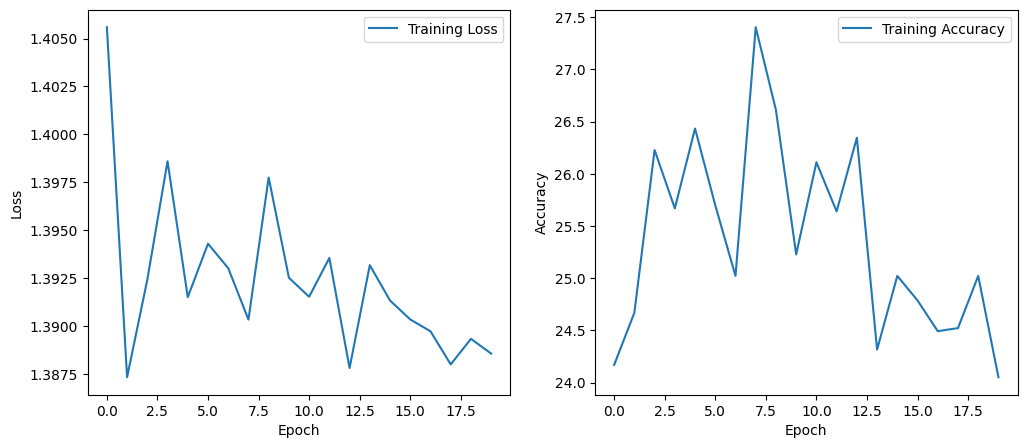

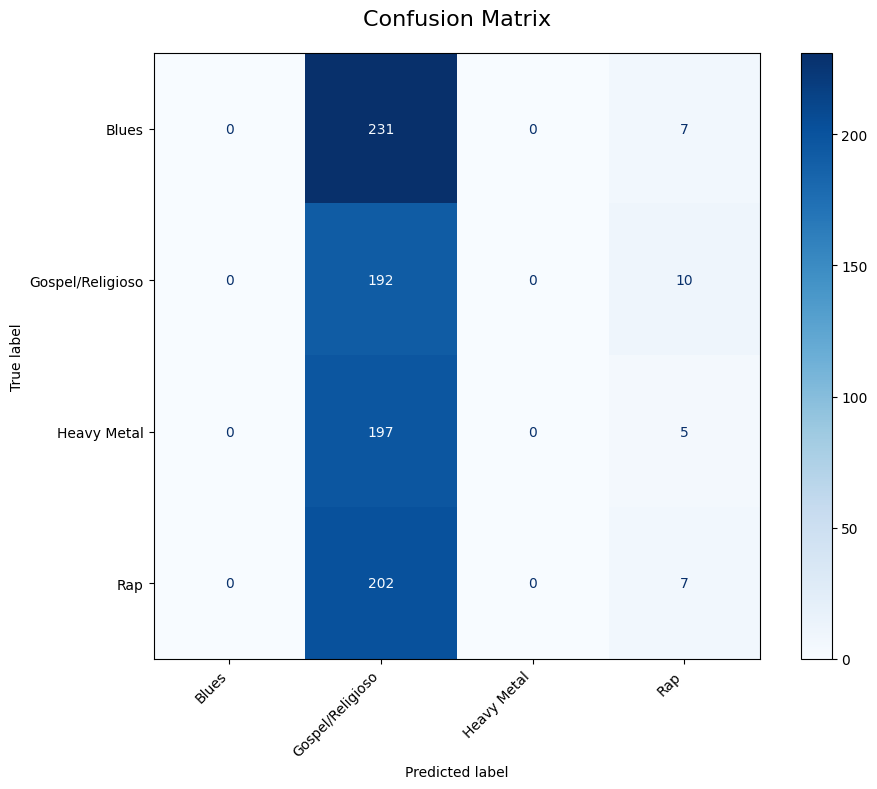

Final Accuracy: 23.38%


In [123]:
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(df['Genre_encoded'].unique())

model = SimpleGNN(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        batch_size = inputs.size(0)
        adj_batch = adj_train[:batch_size, :batch_size]  # Slice the adjacency matrix for the current batch
        outputs = model(inputs, adj_batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Accuracy: {100 * correct / total}')

# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        batch_size = inputs.size(0)
        adj_batch = adj_test[:batch_size, :batch_size]
        outputs = model(inputs, adj_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Confusion matrix
plot_confusion_matrix(y_true, y_pred, label_encoder.classes_)

# Print final accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

## Using K nearest neighbours for similarity in GCN

In [124]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['Lyric'])

# Compute k-nearest neighbors
k = 5
nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(tfidf_matrix.toarray())
distances, indices = nbrs.kneighbors(tfidf_matrix.toarray())

# Create edge index for k-NN graph
edges = []
for i in range(indices.shape[0]):
    for j in range(1, k):  # Start from 1 to exclude self-loop
        edges.append((i, indices[i, j]))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

x = torch.tensor(tfidf_matrix.toarray(), dtype=torch.float)
y = torch.tensor(df['Genre_encoded'].values, dtype=torch.long)

# Create a Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Split the data into training and testing
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_indices, test_indices = train_test_split(np.arange(data.num_nodes), test_size=0.2, random_state=42)
train_mask[train_indices] = True
test_mask[test_indices] = True
data.train_mask = train_mask
data.test_mask = test_mask

data = data.to(device)

In [125]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x


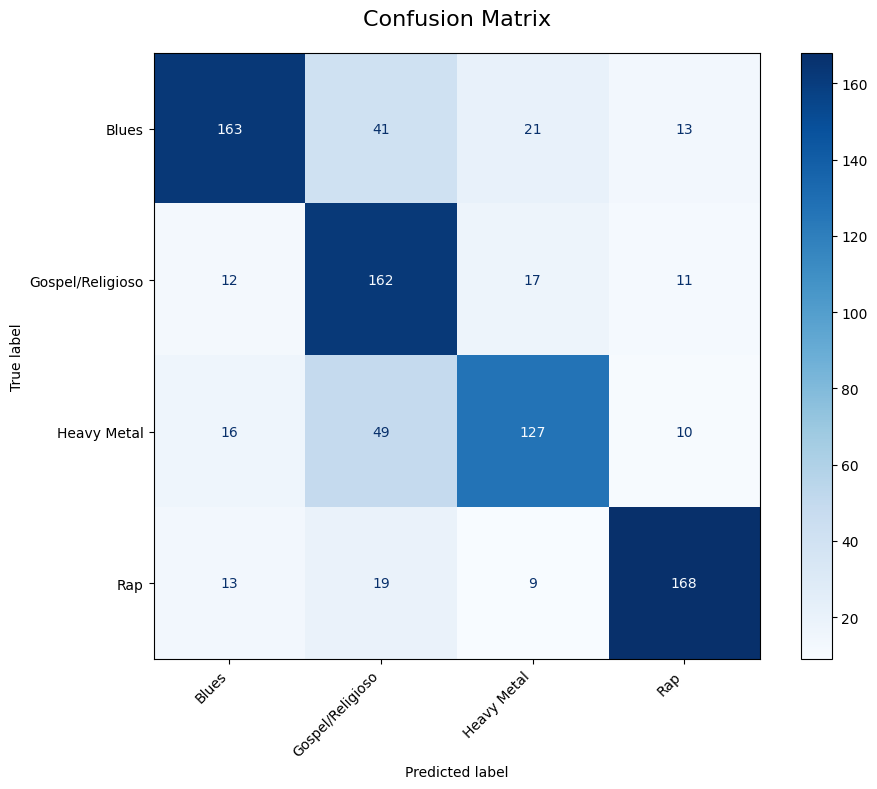

Final Accuracy: 72.86%


In [126]:
model = GCN(input_dim=x.shape[1], hidden_dim=128, output_dim=len(df['Genre_encoded'].unique())).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Calculate class weights to handle class imbalance
class_counts = np.bincount(df['Genre_encoded'])
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    return acc

for epoch in range(1, 10):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')

# Confusion matrix
model.eval()
out = model(data)
pred = out.argmax(dim=1)
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

plot_confusion_matrix(y_true, y_pred, label_encoder.classes_)

# Print final accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Final Accuracy: {accuracy * 100:.2f}%')


## Top K similarities using cosine similarity

In [127]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['Lyric']).toarray()

cos_sim_matrix = cosine_similarity(tfidf_matrix)

k = 5
adj_matrix = np.zeros_like(cos_sim_matrix)
for i in range(cos_sim_matrix.shape[0]):
    top_k_indices = np.argsort(cos_sim_matrix[i])[-k-1:-1]  # Get indices of top k similarities
    adj_matrix[i, top_k_indices] = 1

# Ensure symmetry (undirected graph)
adj_matrix = np.maximum(adj_matrix, adj_matrix.T)

# Prepare data for PyTorch Geometric
edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
x = torch.tensor(tfidf_matrix, dtype=torch.float)
y = torch.tensor(df['Genre_encoded'].values, dtype=torch.long)

# Create a Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Split the data into training and testing
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_indices, test_indices = train_test_split(np.arange(data.num_nodes), test_size=0.2, random_state=42)
train_mask[train_indices] = True
test_mask[test_indices] = True
data.train_mask = train_mask
data.test_mask = test_mask

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)


Epoch: 010, Loss: 0.6653, Test Acc: 0.7615
Epoch: 020, Loss: 0.5162, Test Acc: 0.7521
Epoch: 030, Loss: 0.4394, Test Acc: 0.7415
Epoch: 040, Loss: 0.3935, Test Acc: 0.7368
Epoch: 050, Loss: 0.3543, Test Acc: 0.7133
Epoch: 060, Loss: 0.3175, Test Acc: 0.7109
Epoch: 070, Loss: 0.2835, Test Acc: 0.7027
Epoch: 080, Loss: 0.2690, Test Acc: 0.7039
Epoch: 090, Loss: 0.2511, Test Acc: 0.7109
Epoch: 100, Loss: 0.2402, Test Acc: 0.6886
Epoch: 110, Loss: 0.2250, Test Acc: 0.6886
Epoch: 120, Loss: 0.2137, Test Acc: 0.6874
Epoch: 130, Loss: 0.1918, Test Acc: 0.7015
Epoch: 140, Loss: 0.1805, Test Acc: 0.6945
Epoch: 150, Loss: 0.1713, Test Acc: 0.7121
Epoch: 160, Loss: 0.1753, Test Acc: 0.6968
Epoch: 170, Loss: 0.1565, Test Acc: 0.6992
Epoch: 180, Loss: 0.1311, Test Acc: 0.6921
Epoch: 190, Loss: 0.1437, Test Acc: 0.6898
Epoch: 200, Loss: 0.1501, Test Acc: 0.7062


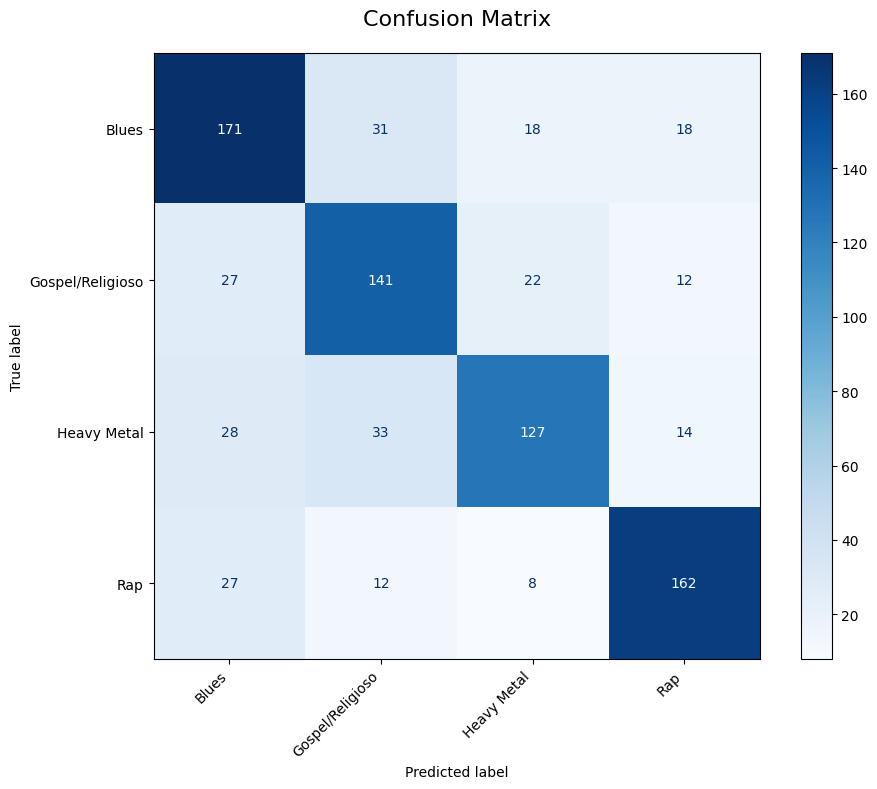

Final Accuracy: 70.62%


In [128]:
model = GCN(input_dim=x.shape[1], hidden_dim=128, output_dim=len(df['Genre_encoded'].unique())).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Calculate class weights to handle class imbalance
class_counts = np.bincount(df['Genre_encoded'])
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    return acc

for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')

# Confusion matrix
model.eval()
out = model(data)
pred = out.argmax(dim=1)
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

plot_confusion_matrix(y_true, y_pred, label_encoder.classes_)
accuracy = accuracy_score(y_true, y_pred)
print(f'Final Accuracy: {accuracy * 100:.2f}%')


## Top K similarities using cosine similarity + Bert Base Uncased Embeddings

In [129]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Tokenize and encode the lyrics in batches
batch_size = 16  # Adjust batch size as needed
lyrics = df['Lyric'].tolist()
embeddings = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for i in range(0, len(lyrics), batch_size):
    batch_lyrics = lyrics[i:i+batch_size]
    encoded_inputs = tokenizer(batch_lyrics, padding=True, truncation=True, max_length=512, return_tensors='pt')
    encoded_inputs = {key: val.to(device) for key, val in encoded_inputs.items()}
    
    with torch.no_grad():
        outputs = model(**encoded_inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)

# Concatenate all batch embeddings
embeddings = np.concatenate(embeddings, axis=0)


In [130]:

# Compute cosine similarity for BERT embeddings
cos_sim_matrix = cosine_similarity(embeddings)

# Create adjacency matrix with top k similarities
k = 5
adj_matrix = np.zeros_like(cos_sim_matrix)
for i in range(cos_sim_matrix.shape[0]):
    top_k_indices = np.argsort(cos_sim_matrix[i])[-k-1:-1]  # Get indices of top k similarities
    adj_matrix[i, top_k_indices] = 1

# Ensure symmetry (undirected graph)
adj_matrix = np.maximum(adj_matrix, adj_matrix.T)

edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
x = torch.tensor(embeddings, dtype=torch.float)
y = torch.tensor(df['Genre_encoded'].values, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)

# Split the data into training and testing
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_indices, test_indices = train_test_split(np.arange(data.num_nodes), test_size=0.2, random_state=42)
train_mask[train_indices] = True
test_mask[test_indices] = True
data.train_mask = train_mask
data.test_mask = test_mask

# Move data to device
data = data.to(device)

Epoch: 010, Loss: 0.7351, Test Acc: 0.7885
Epoch: 020, Loss: 0.5277, Test Acc: 0.8273
Epoch: 030, Loss: 0.4873, Test Acc: 0.8214
Epoch: 040, Loss: 0.4587, Test Acc: 0.8402
Epoch: 050, Loss: 0.4463, Test Acc: 0.8378
Epoch: 060, Loss: 0.4257, Test Acc: 0.8343
Epoch: 070, Loss: 0.4192, Test Acc: 0.8437
Epoch: 080, Loss: 0.4153, Test Acc: 0.8484
Epoch: 090, Loss: 0.4065, Test Acc: 0.8519
Epoch: 100, Loss: 0.3985, Test Acc: 0.8461
Epoch: 110, Loss: 0.3925, Test Acc: 0.8555
Epoch: 120, Loss: 0.3834, Test Acc: 0.8543
Epoch: 130, Loss: 0.3771, Test Acc: 0.8555
Epoch: 140, Loss: 0.3704, Test Acc: 0.8578
Epoch: 150, Loss: 0.3759, Test Acc: 0.8496
Epoch: 160, Loss: 0.3678, Test Acc: 0.8519
Epoch: 170, Loss: 0.3569, Test Acc: 0.8566
Epoch: 180, Loss: 0.3588, Test Acc: 0.8566
Epoch: 190, Loss: 0.3697, Test Acc: 0.8519
Epoch: 200, Loss: 0.3494, Test Acc: 0.8578


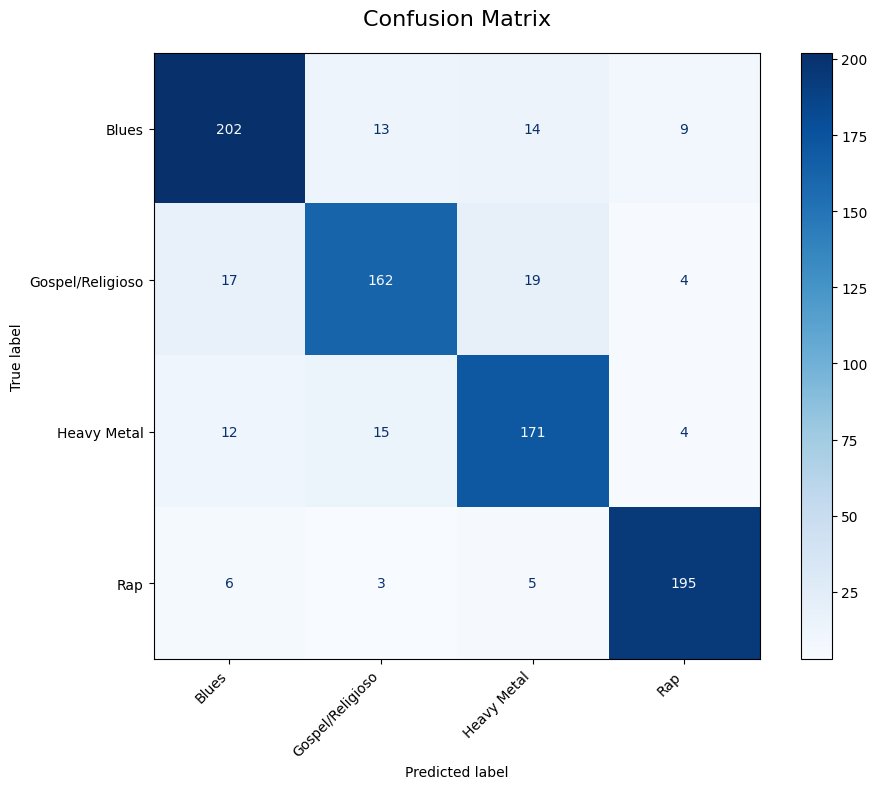

Final Accuracy: 85.78%


In [131]:
model = GCN(input_dim=x.shape[1], hidden_dim=128, output_dim=len(df['Genre_encoded'].unique())).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Calculate class weights to handle class imbalance
class_counts = np.bincount(df['Genre_encoded'])
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    return acc

for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')

# Confusion matrix
model.eval()
out = model(data)
pred = out.argmax(dim=1)
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

plot_confusion_matrix(y_true, y_pred, label_encoder.classes_)

accuracy = accuracy_score(y_true, y_pred)
print(f'Final Accuracy: {accuracy * 100:.2f}%')


## Cosine Similarity + BERT Embeddings in GATs

Epoch: 010, Loss: 2.3565, Test Acc: 0.2703
Epoch: 020, Loss: 1.3704, Test Acc: 0.7309
Epoch: 030, Loss: 1.0218, Test Acc: 0.8002
Epoch: 040, Loss: 0.8547, Test Acc: 0.8026
Epoch: 050, Loss: 0.7843, Test Acc: 0.8167
Epoch: 060, Loss: 0.7513, Test Acc: 0.8237
Epoch: 070, Loss: 0.7055, Test Acc: 0.8261
Epoch: 080, Loss: 0.7003, Test Acc: 0.8261
Epoch: 090, Loss: 0.6848, Test Acc: 0.8237
Epoch: 100, Loss: 0.6424, Test Acc: 0.8273
Epoch: 110, Loss: 0.6290, Test Acc: 0.8284
Epoch: 120, Loss: 0.6289, Test Acc: 0.8308
Epoch: 130, Loss: 0.6117, Test Acc: 0.8296
Epoch: 140, Loss: 0.5905, Test Acc: 0.8261
Epoch: 150, Loss: 0.6040, Test Acc: 0.8284
Epoch: 160, Loss: 0.6035, Test Acc: 0.8355
Epoch: 170, Loss: 0.5906, Test Acc: 0.8331
Epoch: 180, Loss: 0.5637, Test Acc: 0.8343
Epoch: 190, Loss: 0.5691, Test Acc: 0.8308
Epoch: 200, Loss: 0.5632, Test Acc: 0.8331


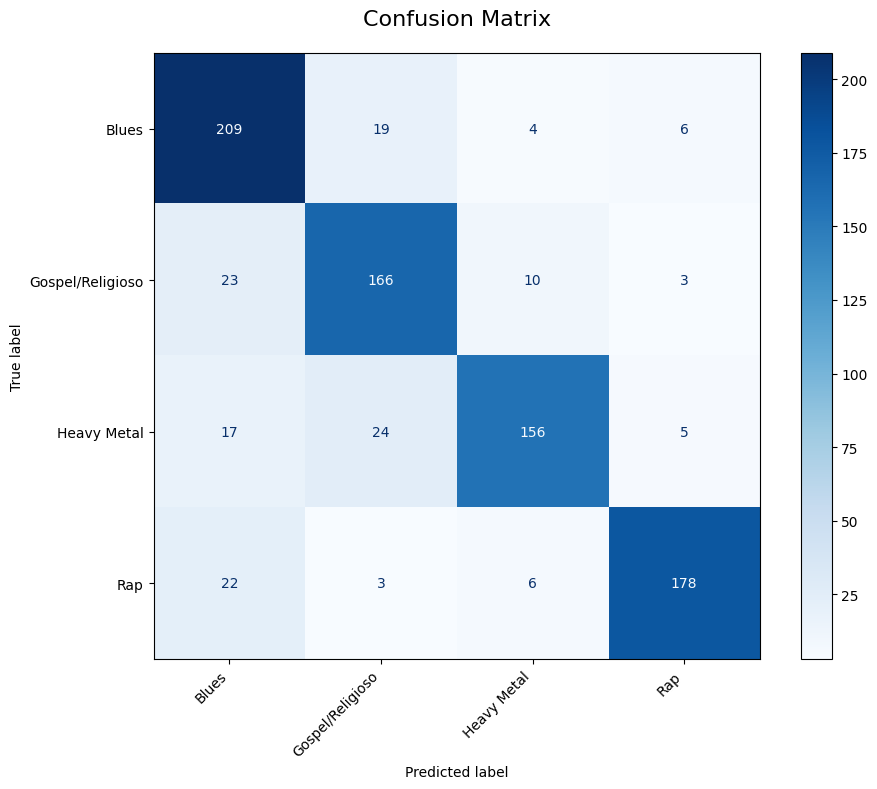

Final Accuracy: 83.31%


In [132]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.6)
        self.conv3 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.6)
        self.dropout = torch.nn.Dropout(p=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

model = GAT(input_dim=x.shape[1], hidden_dim=128, output_dim=len(df['Genre_encoded'].unique()), heads=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Calculate class weights to handle class imbalance
class_counts = np.bincount(df['Genre_encoded'])
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    return acc

# Training and testing
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')

# Confusion matrix
model.eval()
out = model(data)
pred = out.argmax(dim=1)
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()


plot_confusion_matrix(y_true, y_pred, label_encoder.classes_)

# Print final accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Final Accuracy: {accuracy * 100:.2f}%')
